# Chapter 13

In [1]:
from PIL import Image
import webgpupy as np
from functools import reduce
from random import random
from math import radians, tan, pi, cos
from time import time

In [2]:
class Vec3:
    def __new__(cls, x: float=0, y:float=0, z:float=0):
        return np.array([x, y, z], dtype='float32')

Point3=Vec3
Color=Vec3

class VecUtils:
    @staticmethod
    def x(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,0].reshape((image_height, image_width, 1))

    @staticmethod
    def y(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,1].reshape((image_height, image_width, 1))
    
    @staticmethod
    def z(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,2].reshape((image_height, image_width, 1))

    @staticmethod
    def unit_vector(data):
        e0 = VecUtils.x(data)
        e1 = VecUtils.y(data)
        e2 = VecUtils.z(data)
        return data / np.sqrt((e0*e0+e1*e1+e2*e2))
    
    @staticmethod
    def dot(data1, data2):
        data1_x = VecUtils.x(data1)
        data1_y = VecUtils.y(data1)
        data1_z = VecUtils.z(data1)
        data2_x = VecUtils.x(data2)
        data2_y = VecUtils.y(data2)
        data2_z = VecUtils.z(data2)
        return data1_x * data2_x + data1_y * data2_y + data1_z * data2_z
    
    @staticmethod
    def cross(data1, data2):
        return np.cross(data1, data2)

    @staticmethod
    def length_squared(data):
        return VecUtils.dot(data, data)
    
    @staticmethod
    def length(data):
        return np.sqrt(VecUtils.dot(data, data))
    
    @staticmethod
    def near_zero(data):
        s = 1e-8
        data = np.absolute(data)
        e0 = VecUtils.x(data) < s
        e1 = VecUtils.y(data) < s
        e2 = VecUtils.z(data) < s

        result = np.bitwise_and(e0, e1)
        return np.bitwise_and(result, e2)
    
    @staticmethod
    def reflect(v, n):
        return v - 2.0*VecUtils.dot(v,n)*n
    
    @staticmethod
    def refract(uv, n, etai_over_etat):
        cos_theta = np.minimum(VecUtils.dot(-uv, n), 1.0)
        r_out_perp =  etai_over_etat * (uv + cos_theta*n)
        r_out_parallel = -np.sqrt(np.absolute(1.0 - VecUtils.length_squared(r_out_perp))) * n
        return r_out_perp + r_out_parallel

class Rays:
    def __init__(self, origin, direction) -> None:
        self.orig = origin
        self.dir = direction

    def origin(self):
        return self.orig

    def direction(self):
        return self.dir

    def at(self, t):
        return self.orig + t*self.dir


In [ ]:
FARAWAY = np.array([1.0e37])
rng = np.random.default_rng()
t_min = 0.001

def convert_to_image(pixels, samples_per_pixel):
    print(pixels.shape)
    pixels = pixels/float(samples_per_pixel)
    pixels = np.sqrt(pixels)
    pixels = np.clip(pixels, 0.0, 0.999)
    pixels = (pixels * 255.0).astype('uint8')
    pixels = pixels.tolist()
    print(time() - start)
    import numpy
    image_array = numpy.array(pixels, dtype= 'uint8')
    return Image.fromarray(image_array, 'RGB')

In [4]:
def random_array(shape):
    return rng.random(shape)

def random_array_bn(shape, min_value, max_value):
    return min_value + (max_value -(min_value)) * random_array(shape)

def random_in_unit_sphere(shape):
    rand_array = random_array_bn(shape, -1.0, 1.0)
    unit_rand_array = VecUtils.unit_vector(rand_array)
    length_squared = VecUtils.length_squared(rand_array)
    valid_rands = length_squared < 1.0
    rand_array = np.where(valid_rands, rand_array, unit_rand_array)
    return rand_array

def random_unit_vector(shape):
    return VecUtils.unit_vector(random_in_unit_sphere(shape))

def random_in_unit_disk(shape):
    x = np.broadcast_to(np.array([1.0, 0.0, 0.0]), shape)
    y = np.broadcast_to(np.array([0.0, 1.0, 0.0]), shape)
    r1 = random_array_bn(shape, -1.0, 1.0)
    r2 = random_array_bn(shape, -1.0, 1.0)
    rand_array = x * r1 + y * r2
    unit_rand_array = VecUtils.unit_vector(rand_array)
    length_squared = VecUtils.length_squared(rand_array)
    valid_rands = length_squared <1.0
    rand_array = np.where(valid_rands, rand_array, unit_rand_array)
    return rand_array

In [5]:
class Lambertian:
    def __init__(self, color) -> None:
        self.albedo = color

    def scatter(self, r_in: Rays, normal, front_face, hit):
        shape = r_in.origin().shape
        attenuation = np.broadcast_to(self.albedo, shape)
        scatter_direction = normal + random_unit_vector(shape)

        scatter_direction = np.where(VecUtils.near_zero(scatter_direction), normal, scatter_direction)
        attenuation = np.where(hit, attenuation, 0.0)
        scatter_direction  = np.where(hit, scatter_direction, 0.0)
        return (attenuation, scatter_direction, hit)
    
class Metal:
    def __init__(self, color, fuzz: float) -> None:
        self.albedo = color
        self.fuzz = min(fuzz, 1.0)

    def scatter(self, r_in: Rays, normal, front_face, hit):
        shape = r_in.origin().shape
        attenuation = np.broadcast_to(self.albedo, shape)
        reflected = VecUtils.reflect(VecUtils.unit_vector(r_in.direction()), normal)
        reflected += self.fuzz * random_in_unit_sphere(reflected.shape)

        hit = np.bitwise_and(VecUtils.dot(reflected, normal) > 0.0, hit)
        attenuation = np.where(hit, attenuation, 0.0)
        reflected = np.where(hit, reflected, 0.0)
        return (attenuation, reflected, hit)
    
class Dielectric:
    def __init__(self, index_of_refraction: float) -> None:
        self.ir = index_of_refraction

    def scatter(self, r_in: Rays, normal, front_face, hit):
        shape = r_in.origin().shape
        attenuation = np.ones(shape)
        attenuation = np.where(hit, attenuation, 0.0)
        refraction_ratio = np.broadcast_to(np.array(self.ir), normal.shape)
        refraction_ratio = np.where(front_face, (1.0/refraction_ratio), refraction_ratio)

        unit_direction = VecUtils.unit_vector(r_in.direction())

        cos_theta = np.minimum(VecUtils.dot(-unit_direction, normal), 1.0)
        sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
        cannot_refract = refraction_ratio * sin_theta > 1.0
        cannot_refract = np.bitwise_or(cannot_refract, self._reflectance(cos_theta, refraction_ratio) > random())

        direction = np.where(cannot_refract, 
                             VecUtils.reflect(unit_direction, normal), 
                             VecUtils.refract(unit_direction, normal, refraction_ratio))

        direction = np.where(hit, direction, 0.0)
        return (attenuation, direction, hit)

    @classmethod
    def _reflectance(cls, cosine, ref_idx):
        r0 = (1.0-ref_idx) / (1.0+ref_idx)
        r0 = r0*r0
        return r0 + (1.0-r0)*np.power((1.0 - cosine),5.0)

In [6]:
class Sphere:
    def __init__(self, center, radius: float, material) -> None:
        self.radius = radius
        self.center = center
        self.material = material
    
    def hit(self, r: Rays):
        oc = r.origin() - self.center
        a = VecUtils.dot(r.direction(), r.direction())
        half_b = VecUtils.dot(oc, r.direction())
        c = VecUtils.dot(oc, oc) - self.radius*self.radius
        discriminant = half_b*half_b - a*c

        sqrtd = np.sqrt(np.maximum(0.0, discriminant))

        root1 = (-half_b - sqrtd) / a
        root2 = (-half_b + sqrtd) / a
        root = np.where((root1 > 0.0) & (root1 < root2), root1, root2)
        pred = (discriminant > 0.0) & (root > 0.0)
        return np.where(pred, root, FARAWAY)

    def color(self, r: Rays, t, hit):
        t = t * hit.astype('float32')
        hit_point = r.at(t)
        outward_normal = (hit_point - self.center) / self.radius
        front_face = VecUtils.dot(r.direction(), outward_normal) < 0.0
        normal = np.where(front_face, outward_normal, -outward_normal)
        normal = np.where(hit, normal, 0.0)

        return self.material.scatter(r, normal, front_face, hit)

class World:
    def __init__(self) -> None:
        self.hittable_list = []

    def add(self, object):
        self.hittable_list.append(object)
    
    def color(self, rays: Rays):
        
        t_values = []

        for object in self.hittable_list:
            t_values.append(object.hit(rays))

        nearest = reduce(np.minimum, t_values)
        nearest = np.maximum(nearest, 0.001)
        image_shape = rays.origin().shape
        color = np.zeros(image_shape)
        ray_direction = np.zeros(image_shape)
        new_hit = np.zeros(nearest.shape, dtype='bool')
        for (s, t) in zip(self.hittable_list, t_values):
            sphere_hit = (nearest != FARAWAY) & (t == nearest)
            if np.any(sphere_hit):
                (attenuation, scatter_direction, ray_hit) = s.color(rays, t, sphere_hit)
                color += attenuation
                ray_direction += scatter_direction
                new_hit = np.bitwise_or(new_hit, ray_hit)

        t_values = nearest * new_hit.astype('float32')
        ray_direction = np.where(new_hit, ray_direction, rays.direction())
        return (color, t_values, ray_direction, new_hit)
    
class Camera:
    def __init__(self,
                 lookfrom,
                 lookat,
                 vup,
                 vfov, #vertical field-of-view in degrees
                 aspect_ratio, 
                 aperture,
                 focus_dist,
                 image_width, 
                 image_height) -> None:
        theta = radians(vfov)
        h = tan(theta/2)
        viewport_height = 2.0  * h
        viewport_width = aspect_ratio * viewport_height

        self.w = VecUtils.unit_vector(lookfrom - lookat)
        self.u = VecUtils.unit_vector(VecUtils.cross(vup, self.w))
        self.v = VecUtils.cross(self.w, self.u)

        self.origin = np.broadcast_to(lookfrom, ((image_height, image_width, 3)))
        self.horizontal = np.broadcast_to(self.u* viewport_width, ((image_height, image_width, 3))) * focus_dist
        self.vertical = np.broadcast_to(self.v* viewport_height, ((image_height, image_width, 3))) * focus_dist
        self.lower_left_corner = self.origin - self.horizontal/2.0 - self.vertical/2.0 - self.w * focus_dist

        self.lens_radius = aperture / 2.0

    def get_ray(self, s, t):
        rd = self.lens_radius * random_in_unit_disk(self.origin.shape)
        offset = self.u * VecUtils.x(rd) + self.v * VecUtils.y(rd)
        return Rays(self.origin + offset, 
                    self.lower_left_corner + s*self.horizontal + t*self.vertical - self.origin - offset)

In [7]:
def ray_color(shape, rays: Rays, world, depth):

    if (depth <= 0):
        return np.zeros(shape)

    (world_color, t_values, ray_direction, hit) = world.color(rays)
    not_hit = np.invert(hit)
    if np.any(hit):
        hit_points = rays.at(t_values)
        world_color = world_color * ray_color(shape, Rays(hit_points, ray_direction), world, depth-1)

    dir = rays.direction()
    unit_direction = VecUtils.unit_vector(dir)
    t = 0.5*(VecUtils.y(unit_direction) + 1.0)
    is_not_hit_color = ((1.0-t)*Color(1.0, 1.0, 1.0) + t*Color(0.5, 0.7, 1.0)) * not_hit.astype("float32")
    return world_color + is_not_hit_color

finished sample 9 in 1.9095172882080078s
[360, 640, 3]
18.955835103988647


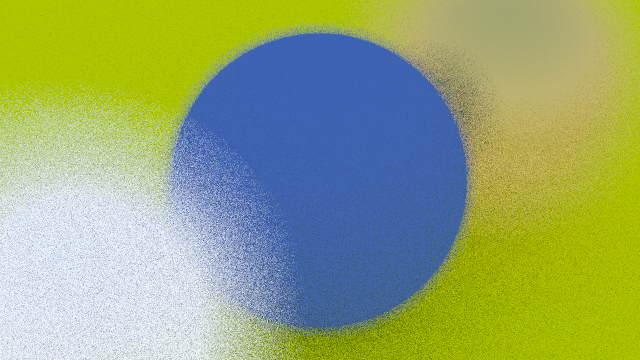

In [8]:
image_height = 360
aspect_ratio = 16/9
image_width = int(image_height * aspect_ratio)
samples_per_pixel = 10
max_depth = 5
start = time()

u = np.array([[i/(image_width - 1) for i in range(0, image_width)]])
u = np.repeat(u, image_height, axis=0).reshape([image_height, image_width, 1])
v = np.array([i/(image_height - 1) for i in range(image_height-1, -1, -1)]).reshape([image_height, 1])
v = np.repeat(v, image_width, axis=1).reshape([image_height, image_width, 1])

R = cos(pi/4)
lookfrom = np.array([[[-2.0, 2.0, 1.0]]])
lookat = np.array([[[0.0, 0.0,-1.0]]])
vup = np.array([[[0.0, 1.0, 0.0]]])
dist_to_focus = VecUtils.length(lookfrom - lookat)
aperture = 2.0
cam = Camera(
    lookfrom, 
    lookat, 
    vup, 
    20, 
    aspect_ratio, 
    aperture, 
    dist_to_focus, 
    image_width, 
    image_height
)

world = World()
material_ground = Lambertian(Color(0.8, 0.8, 0.0))
material_center = Lambertian(Color(0.1, 0.2, 0.5))
material_left   = Dielectric(1.5)
material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

world.add(Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground))
world.add(Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center))
world.add(Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left))
world.add(Sphere(Point3(-1.0,    0.0, -1.0), -0.45, material_left))
world.add(Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right))

pixels = np.zeros((image_height, image_width, 3))
time_take_per_sample = start
for i in range(0, samples_per_pixel):
    new_u = u + (random_array(u.shape) / float(image_width - 1))
    new_v = v + (random_array(v.shape) / float(image_height - 1))
    rays = cam.get_ray(new_u, new_v)
    pixels += ray_color((image_height, image_width, 3), rays, world, max_depth)
    time_take_per_sample = time() - time_take_per_sample
    print(f'finished sample {i} in {time_take_per_sample}s', end='\r')
    time_take_per_sample = time()
print()

convert_to_image(pixels, samples_per_pixel)